### CASA0002

# Urban Simulation
***
## Community Detection

Mateo Neira
***

In this lab we well go over the practical implementation of some of the community detection algorithms we've seen this week. We will first look at an artificial social network for a short intro into how to use these algorithms, visualize results, and measure their performance. Then we will have an intro into **OSMnx**, a python library to parse [OpenStreetMap](https://www.openstreetmap.org/) data.

***

Apart from **NetworkX** we will be using [CDlib](https://cdlib.readthedocs.io/en/latest/), a python library for community detection algorithms. 

To be able to use **CDlib** you will need to install the library using pip along with some additional dependencies.

```shell
pip install CDlib
```

In [1]:
import networkx as nx
import osmnx as ox
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### A Short Intro to Community Detection in Python

We will be using [NetworkX](http://networkx.org/documentation/networkx-2.5/) to create our networks and the [CDlib](https://cdlib.readthedocs.io/en/latest/) python library to run the different community detection algorithms.

In some cases we will use community detection algorithms available from the NetworkX library, you can check the available algorithms [here](http://networkx.org/documentation/networkx-2.5/reference/algorithms/community.html).

Before we get into the **Urban/Spatial** side of things, where we will be looking at how to build a street network graph and find *neighbourhoods* from the network topology, we are going in a little detour just to show you how to to use the community detection algorithms in python for social networks.

### Exploring the Marvel Universe

![](marvel.jpg)

We will be using the Marvel Universe as an example of a social collaboration network. The network was created by Cesc Rosselló and Ricardo Alberich. You can find the original data source [here](http://bioinfo.uib.es/~joemiro/marvel.html)

#### About the network

Nodes in the network are Marvel characters, these characters are linked if they jointly appear in the same Marvel comic book. The data was collected from the [Marvel Chronology Project](https://www.chronologyproject.com/). The network was built by projecting the bipartite graph connecting characters to comics. 

![bipartite.png](bipartite.png)



In [2]:
# let's read the data and quickly see what we have
marvel_network = pd.read_csv('data/hero-network.csv')
marvel_network.head(10)

,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
5,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
6,"STEELE, SIMON/WOLFGA","FORTUNE, DOMINIC"
7,"STEELE, SIMON/WOLFGA","ERWIN, CLYTEMNESTRA"
8,"STEELE, SIMON/WOLFGA",IRON MAN/TONY STARK
9,"STEELE, SIMON/WOLFGA",IRON MAN IV/JAMES R.


In [3]:
# ok, the data is an edge list with connections between characters that co-appear
# we can create the network using networkx from_pandas_edgelist
G = nx.from_pandas_edgelist(marvel_network, 'hero1', 'hero2')

# let's also plot some basic information about the network
# print(nx.info(G))
print(f'Number of connected components:{nx.number_connected_components(G)}')
print(f'Highest degree node: {sorted(G.degree(), key=lambda pair: pair[1])[-1]}')

Number of connected components:4
Highest degree node: ('CAPTAIN AMERICA', 1908)


In [4]:
# we will get the position of the nodes once so we don't need to recalculate every time we plot
pos = nx.spring_layout(G)

# more layouts at https://networkx.org/documentation/stable/reference/drawing.html

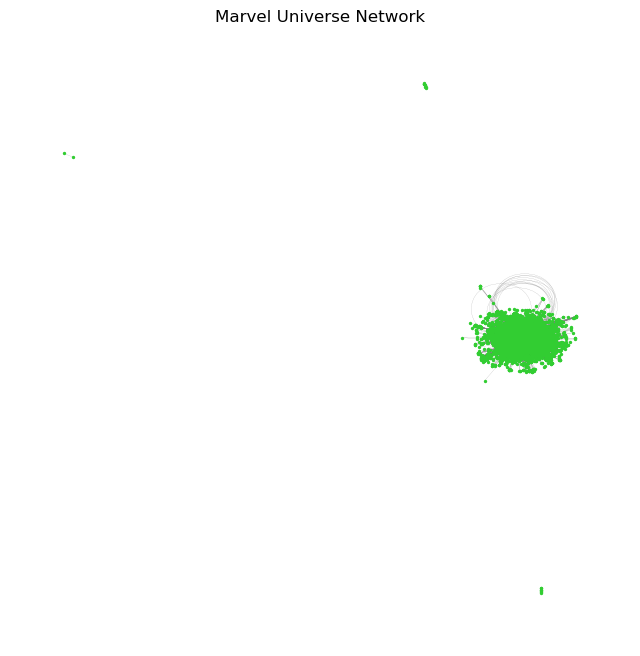

In [5]:
fig, ax = plt.subplots(figsize=(8,8))
nx.draw_networkx_edges(G,
                       pos=pos,
                       edge_color='gray',
                       width=0.1,
                       ax=ax
                      )
nx.draw_networkx_nodes(G, 
                       pos=pos,
                       node_color='limegreen',
                       node_size=2,
                       ax=ax
                      )
plt.axis("off")
plt.title('Marvel Universe Network', fontsize=12)
plt.show()

In [6]:
# we can see in the plot that the graph has more then one component
# let's subset this graph to the largest connected component
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
Gsub = G.subgraph(Gcc[0])

# calculate the percentage of nodes present in the largest connected components
percent_lcc = (len(Gsub.nodes)/len(G.nodes)) * 100

lb = '\n \t'
print(f'Largest Connected Compenent:{percent_lcc:.2f}%')
# print(nx.info(Gsub))
print(f'Number of connected components:{nx.number_connected_components(Gsub)}')
print(f"Highest degree nodes: \n \t" \
        f"{lb.join(f'{hero[0]}: {hero[1]}' for hero in sorted(Gsub.degree(), key=lambda pair: pair[1], reverse=True)[0:5])}")

Largest Connected Compenent:99.72%
Number of connected components:1
Highest degree nodes: 
 	CAPTAIN AMERICA: 1908
 	SPIDER-MAN/PETER PAR: 1737
 	IRON MAN/TONY STARK : 1522
 	THING/BENJAMIN J. GR: 1416
 	MR. FANTASTIC/REED R: 1379


C:\Users\cege\AppData\Local\Temp\ipykernel_11688\2156028632.py:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b." (-> color='b'). The keyword argument will take precedence.
  ax2.loglog(np.arange(degree_prob.shape[0]),degree_prob,'b.', color='darkred', markersize=2)


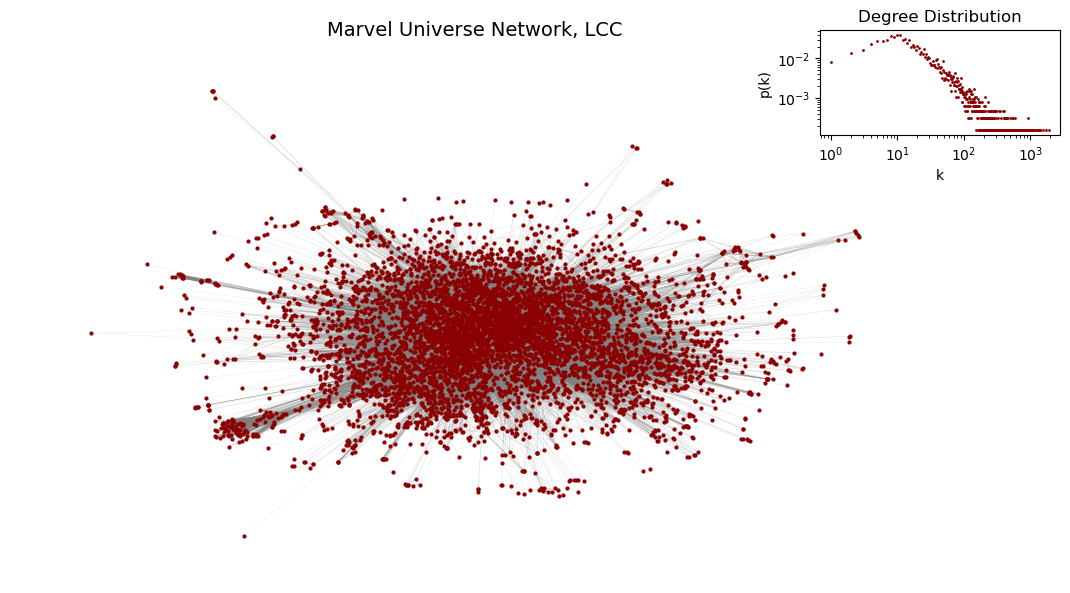

In [7]:
fig, ax = plt.subplots(figsize=(12,7))

# plot largest connected components
nx.draw_networkx_edges(Gsub,
                       pos=pos,
                       edge_color='gray',
                       width=0.1,
                       alpha=0.5,
                       ax=ax
                      )
nx.draw_networkx_nodes(Gsub, 
                       pos=pos,
                       node_color='darkred',
                       node_size=4,
                       ax=ax
                      )
ax.axis('off')
ax.set_title('Marvel Universe Network, LCC', fontsize=14)

# plot the degree distribution
# degree distribution will be covered next lecture 

degree_hist = nx.degree_histogram(G) 
degree_hist = np.array(degree_hist, dtype=float)
degree_prob = degree_hist/G.number_of_nodes()

ax2 = fig.add_axes([0.8, 0.75, 0.2, 0.15])
ax2.loglog(np.arange(degree_prob.shape[0]),degree_prob,'b.', color='darkred', markersize=2)
ax2.set_xlabel('k')
ax2.set_ylabel('p(k)')
ax2.set_title('Degree Distribution')


plt.show()

#### What communities can we find in this marvel universe?

We will start by measuring the clustering coefficients of the network.

Remember:

$$ C_i = \frac{2L_i}{k_i(k_i-1)} $$

where $ L_i $ represents the number of links between the  $ k_i $ neighbours of node $i$. 

$C$ in $[0,1]$

In [8]:
# let's measure the clustering coefficient
c = nx.clustering(Gsub)
print(type(c))

# we can sort the dictionary by the clustering coefficient
c = sorted(c.items(), key=lambda pair: pair[1], reverse=True)
print(c[:5])

#what is the average clustering coefficient
c_avg = sum([i[1] for i in c]) / len(c)
print(f'avg clustering coefficient: {c_avg}')

<class 'dict'>
[('ZANIAC/BRAD WOLFE', 1.0), ('LUMLEY, JUDY', 1.0), ('MCCORMICK, BARRY', 1.0), ('STAR THIEF II', 1.0), ('CONOVER, REV. WILLIA', 1.0)]
avg clustering coefficient: 0.7744001182184536


**Exercise (for the future)**

To be able to interpret the average clustering coefficient we need to compare with a null model. 

1. build a random graph with the same number of nodes and edges as our artificial graph
2. calculate the average clustering coefficient, how do they compare?

---

Additionally, think about the fact the the co-appearance network was built from a the bipartite graph contains 6,486 nodes corresponding to characters and 12,942 nodes corresponding to comic books, and 96,662 edges going from the characters to the books where they appear.

Can you think of a better null model?

Here is a paper by Newman, Strogatz, Watts [Random graphs with arbitrary degree distributions and their applications](https://static.squarespace.com/static/5436e695e4b07f1e91b30155/t/5445263ee4b0d3d410795e1f/1413817918272/random-graphs-with-arbitrary-degree-distributions-and-their-applications.pdf) that touches on this. 



#### Ok, can we partition this graph into something meaningful?

In [9]:
from networkx.algorithms.community import greedy_modularity_communities
import itertools

# let's start with greedy modularity
communities_fg = greedy_modularity_communities(Gsub)

print(f'number of communities: {len(communities_fg)}')

number of communities: 66


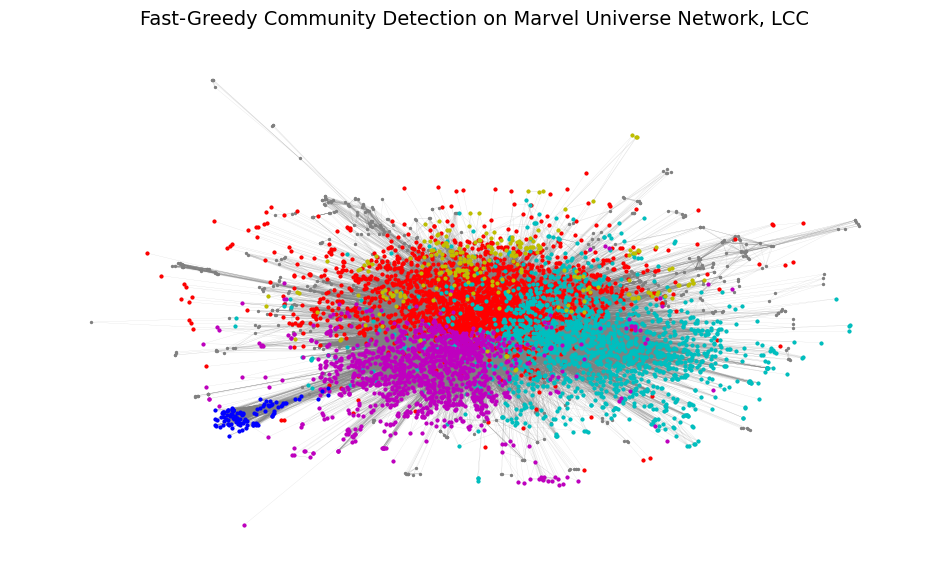

In [10]:
# we can sort this communities to plot only the largest communities 
communities_fg = sorted(communities_fg)

fig, ax = plt.subplots(figsize=(12,7))

# plot the entire graph with gray nodes
nx.draw_networkx_nodes(Gsub, 
                       pos=pos,
                       node_color='grey',
                       node_size=2,
                       ax=ax, 
                      )

nx.draw_networkx_edges(Gsub,
                       pos=pos,
                       edge_color='gray',
                       width=0.1,
                       alpha=0.5,
                       ax=ax
                      )

# set the colors we will be using for each community
cls = ['r', 'c', 'm', 'y', 'b']
i=0
while i<5:
    nx.draw_networkx_nodes(Gsub, 
                           pos=pos,
                           node_color=cls[i],
                           node_size=4,
                           ax=ax, 
                           nodelist= list(communities_fg[i])
                          )
    i+=1
    
plt.axis('off')
plt.title('Fast-Greedy Community Detection on Marvel Universe Network, LCC', fontsize=14)

plt.show()

In [11]:
# we will get the degree of each nodes and sort them from highest to lowest
# this will let us get a better idea about who is in each community by just looking at high degree characters
deg = sorted(Gsub.degree(), key=lambda pair: pair[1], reverse=True)

In [12]:
for i, community in enumerate(communities_fg[:5]):
    c = list(community)
    top_5 = [hero[0] for hero in deg if hero[0] in c][:5]
    print(f'community {i}:')
    for hero in top_5:
        print(f'\t {hero}')
    

community 0:
	 CAPTAIN AMERICA
	 IRON MAN/TONY STARK 
	 THING/BENJAMIN J. GR
	 MR. FANTASTIC/REED R
	 HUMAN TORCH/JOHNNY S
community 1:
	 SPIDER-MAN/PETER PAR
	 DAREDEVIL/MATT MURDO
	 JAMESON, J. JONAH
	 WATSON-PARKER, MARY 
	 ROBERTSON, JOE
community 2:
	 WOLVERINE/LOGAN 
	 BEAST/HENRY &HANK& P
	 STORM/ORORO MUNROE S
	 PROFESSOR X/CHARLES 
	 COLOSSUS II/PETER RA
community 3:
	 FURY, COL. NICHOLAS 
	 BUCKY/BUCKY BARNES
	 TORO/TOM RAYMOND
	 SPITFIRE/LADY JACQUE
	 PIXIE/ [ETERNAL]
community 4:
	 BRUTE | MUTANT X-VER
	 BLOODSTORM | MUTANT 
	 ICE-MAN | MUTANT X-V
	 SUMMERS, SCOTT III |
	 CAPTAIN AMERICA | MU


In [13]:
# # CDlib is a python library for community detection
# # it has problems with new macs but we will leave this code commented out for anyone who wants to try it
# # check the cdlib documentation for more information about all the algorithms
# from cdlib import algorithms

# # let's try a different algorithm using cdlib
# partitions = algorithms.louvain(Gsub)
# communities_louvain = partitions.communities
# print(f'number of communities: {len(communities_louvain)}')

In [14]:

# communities_louvain = sorted(communities_louvain, key=lambda x: len(x), reverse=True)

# fig, ax = plt.subplots(figsize=(12,7))

# nx.draw_networkx_nodes(Gsub, 
#                        pos=pos,
#                        node_color='grey',
#                        node_size=2,
#                        ax=ax, 
#                       )

# nx.draw_networkx_edges(Gsub,
#                        pos=pos,
#                        edge_color='gray',
#                        width=0.1,
#                        alpha=0.5,
#                        ax=ax
#                       )

# cls = ['r', 'c', 'm', 'y', 'b']
# i=0
# while i<5:
#     nx.draw_networkx_nodes(Gsub, 
#                            pos=pos,
#                            node_color=cls[i],
#                            node_size=4,
#                            ax=ax, 
#                            nodelist= list(communities_louvain[i])
#                           )
#     i+=1
    
# plt.axis('off')
# plt.title('Communities in the Marvel Universe Network, LCC', fontsize=14)

# plt.show()

In [15]:
# for i, community in enumerate(communities_louvain[:5]):
#     c = list(community)
#     top_5 = [hero[0] for hero in deg if hero[0] in c][:5]
#     print(f'community {i}:')
#     for hero in top_5:
#         print(f'\t {hero}')

#### So how good are these partitions?

One way to compare the two partitions we have is to measure the modularity of the resulting network partitions. 

We can do this easily with networkx:
* Modularity
* Performance

https://networkx.org/documentation/networkx-2.5/reference/algorithms/generated/networkx.algorithms.community.quality.modularity.html#networkx.algorithms.community.quality.modularity

In [16]:
# from networkx.algorithms.community.quality import modularity

# print(f'modularity of fast-greedy: {modularity(Gsub, communities_fg)}')
# print(f'modularity of louvain: {modularity(Gsub, communities_louvain)}')

In [17]:
# from networkx.algorithms.community.quality import partition_quality

# print(f'performance of fast-greedy: {partition_quality(Gsub, communities_fg)}')
# print(f'performance of louvain: {partition_quality(Gsub, communities_louvain)}')

### Street Network analysis

Now that we have seen how to discover communities in a network, visualized the results, and seen how to compare and measure performance. Let's go back to applying these in **urban** networks. We will be focusing on Street Networks, and we will be thinking about communities here, as *neighbourhoods* defined by the topology of the network. 

![street network representation](street_networks.png)

from: [Street Network Studies: from Networks to Models and their Representations](https://link.springer.com/article/10.1007/s11067-018-9427-9)

#### the OSMnx library

Python library that lets you download spatial data from OpenStreetMap and analyze street networks.
https://osmnx.readthedocs.io/en/stable/

OSMnx is built on top of GeoPandas, and Networkx:
* Downloads and creates a networkx graph ofstreet networks or other infrastructure networks
    * Automatically cleans(topologically corrects) the network for you. 
* Download any other spatial geometries (buildings, POI's, place boundaries)


In [18]:
# We can build a graph by giving the name of the place
G = ox.graph_from_place('Piedmont, California, USA', network_type='drive')
print(type(G))

<class 'networkx.classes.multidigraph.MultiDiGraph'>


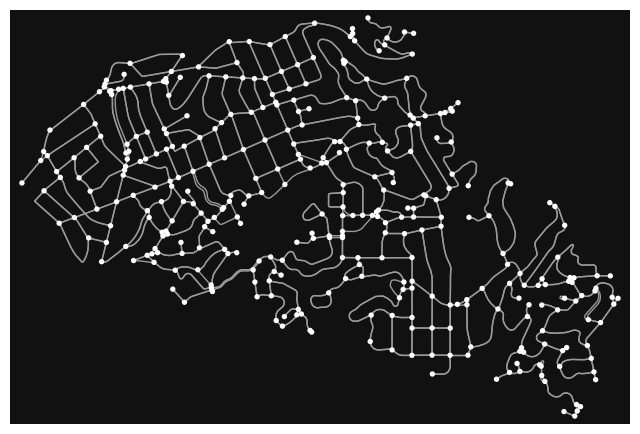

In [19]:
fig, ax = ox.plot_graph(G)

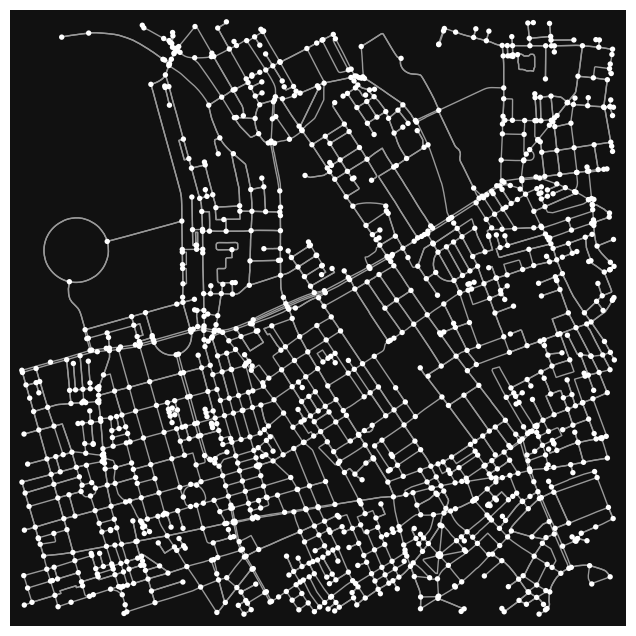

In [20]:
# We can also build a graph by giving the coordinates and a radius
ucl = (51.5245593,-0.1358805)
radius = 1500 #meters
G = ox.graph_from_point(ucl, dist=radius, network_type='drive')
fig, ax = ox.plot_graph(G)

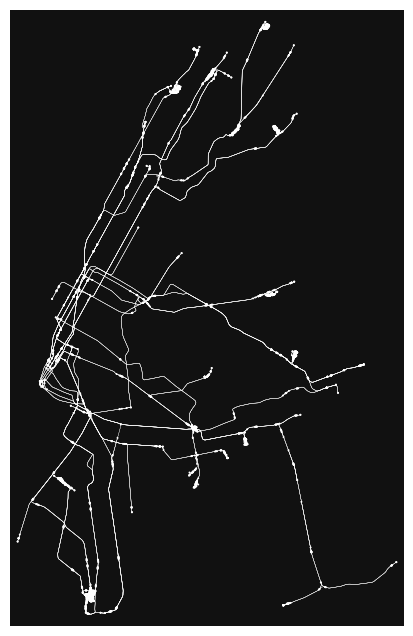

In [21]:
# We can also get other infrastructure networks
# change the overpass query to meet the new style 'New York, NY, USA'
G = ox.graph_from_place('New York, NY, USA',
                        retain_all=False, truncate_by_edge=True, simplify=True,
                        custom_filter='["railway"~"subway"]')

fig, ax = ox.plot_graph(G, node_size=2, edge_color='w', edge_linewidth=0.2)

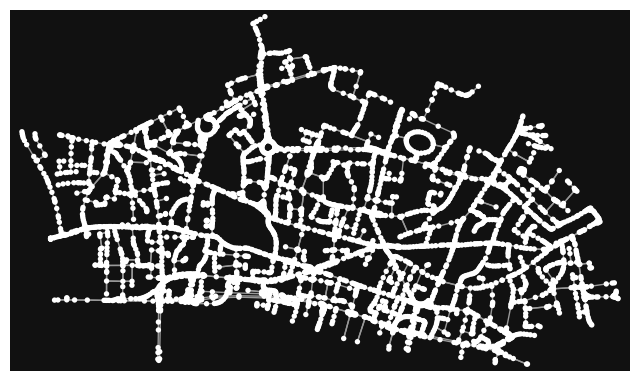

In [22]:
# now onto community detection in street networks
# to keep it light, we will only be using the city of London
place = 'City of London, Greater London, England, United Kingdom'

# I'm setting simplify false here to show how osmnx clean the networks topology
G = ox.graph_from_place(place, network_type='drive', simplify=False)
fig, ax = ox.plot_graph(G)

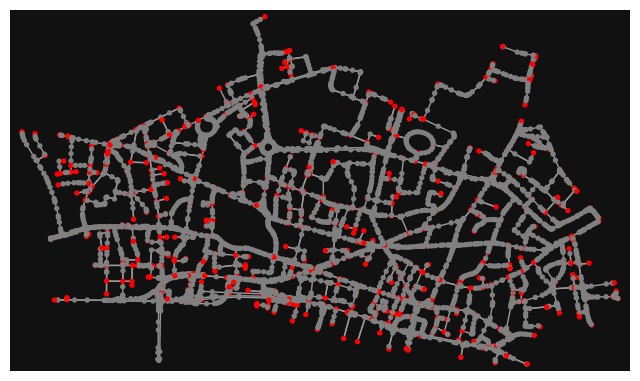

In [275]:
nc = ['r' if ox.simplification._is_endpoint(G, node, None) else 'grey' for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc)

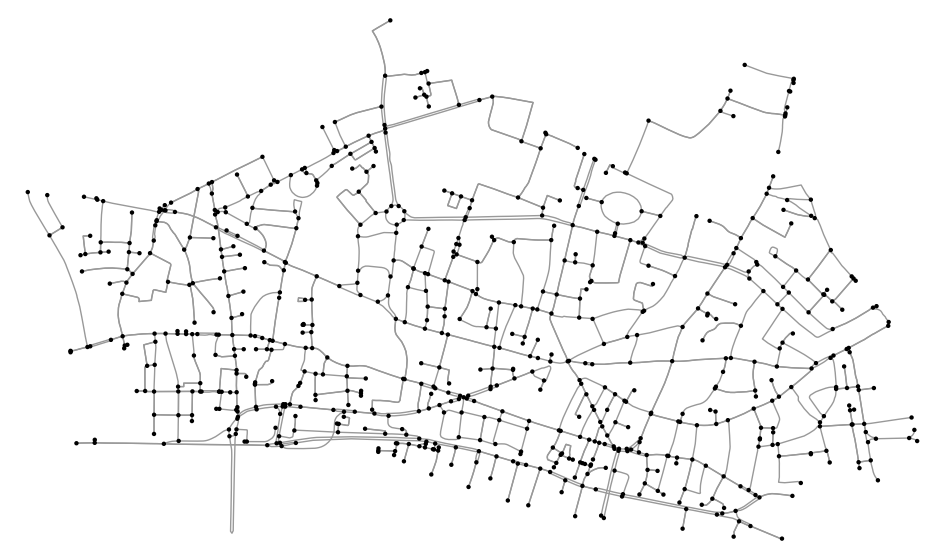

In [276]:
# simplify the network
fig, ax = plt.subplots(figsize=(12,7))
G = ox.simplify_graph(G)
fig, ax = ox.plot_graph(G, 
                        node_color='k',
                        node_size = 10,
                        ax=ax)

In [277]:
# we can calculate basic street network metrics and display average circuity
stats = ox.basic_stats(G)
stats

{'n': 724,
 'm': 1443,
 'k_avg': 3.9861878453038675,
 'edge_length_total': 88780.64200000007,
 'edge_length_avg': 61.525046431046476,
 'streets_per_node_avg': 2.638121546961326,
 'streets_per_node_counts': {0: 0, 1: 139, 2: 57, 3: 466, 4: 52, 5: 9, 6: 1},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.1919889502762431,
  2: 0.0787292817679558,
  3: 0.643646408839779,
  4: 0.0718232044198895,
  5: 0.012430939226519336,
  6: 0.0013812154696132596},
 'intersection_count': 585,
 'street_length_total': 59248.17299999999,
 'street_segment_count': 926,
 'street_length_avg': 63.9829082073434,
 'circuity_avg': 1.0608846011774709,
 'self_loop_proportion': 0.0021598272138228943}

**Exercise**

Now that we have shown you how to build a query to Open Street Map using `custom_filter`, see if you can do one yourself for the city of your choosing.

1. Look at this [table](https://wiki.openstreetmap.org/wiki/Map_features) that shows the names of OSM features
2. Substitute some of those into the query above (where we grab the NYC metro) 
4. Make sure do one query that gets amenities, like restaurants or cafes and do another for a class of road

Hit: points of interest, like amenities, come from `geometries_from_*` rather than `graph_from_*`. Use the "tags" field to choose what kinds of features you want to download in this function. 

---

Something the may be important to your work will be distinguishing "motorway", "primary", "secondary", "tertiary" roads as well as downloading "footpath". Another thing that OSMnx can do is download amenities, which is important to spatial interaction modelling: amenities can take the place of population at destination when we try to model the attractiveness.




In [278]:
# get building footprints for the city of London
buildings = ox.geometries_from_place(place, tags={'building':True})
# get amenities for the city of London
amenities = ox.geometries_from_place(place, tags={'amenity':True, 'geometry':'point'})


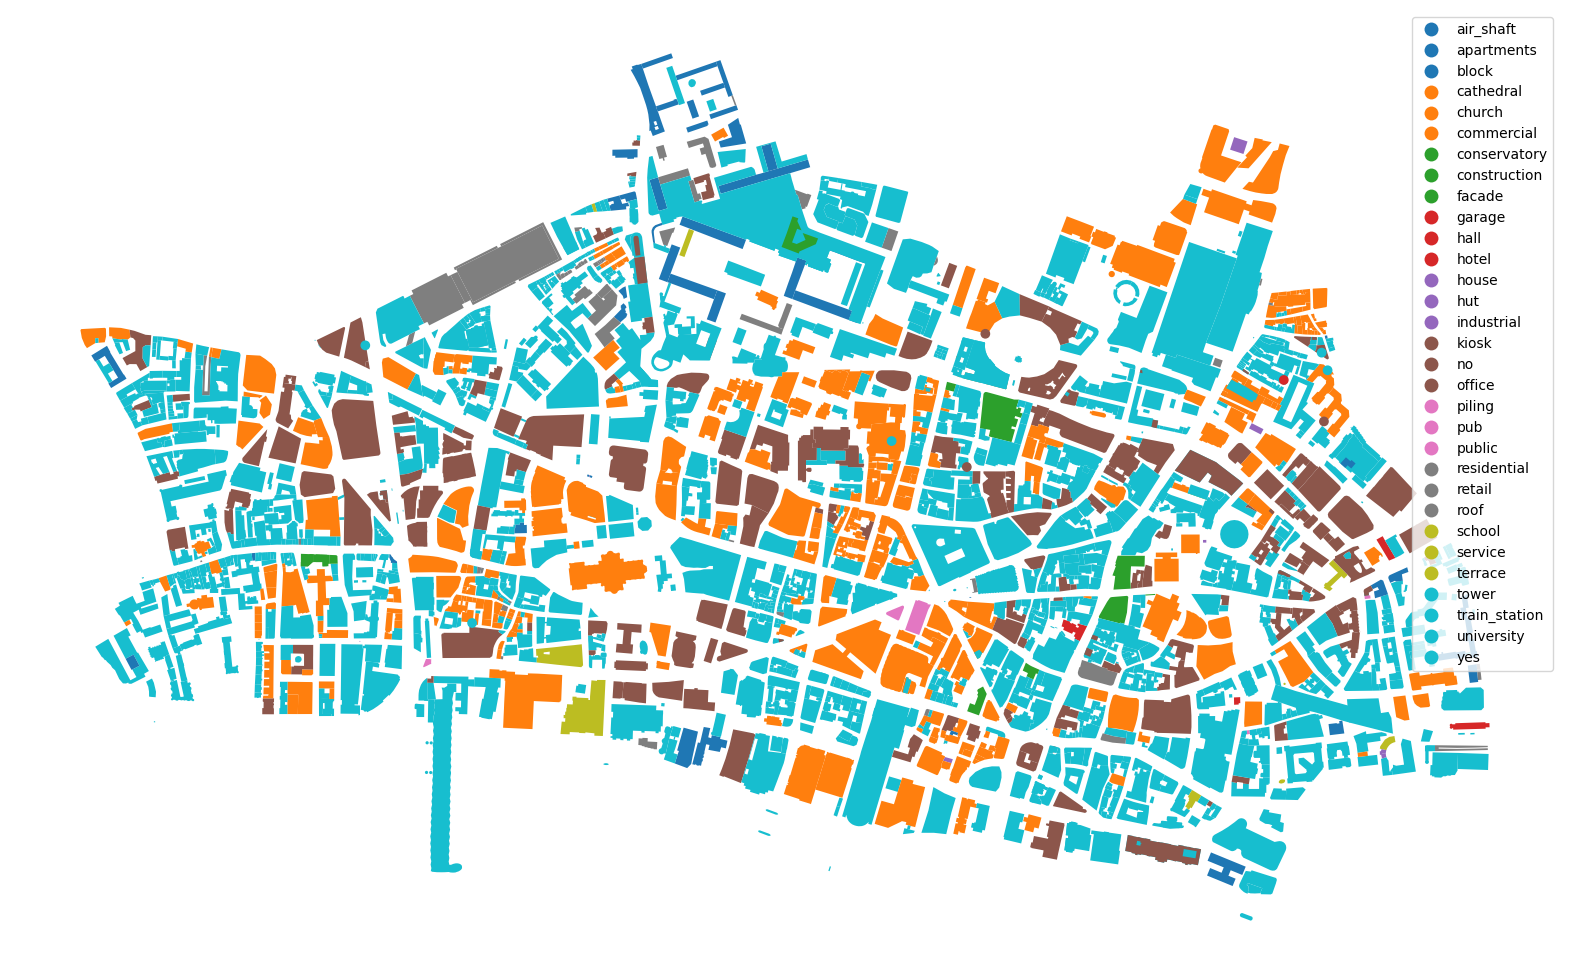

In [279]:
ax = buildings.plot(column='building', figsize=(20, 20), legend=True)
ax.set_axis_off()

/var/folders/xj/s_z3mksd2s9_pz9rv68sbjxc0000gn/T/ipykernel_71939/459010638.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  st_pauls = buildings[buildings.name.str.contains("St Paul's Cathedral", na=False)].geometry.centroid
/var/folders/xj/s_z3mksd2s9_pz9rv68sbjxc0000gn/T/ipykernel_71939/459010638.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  finsbury = amenities[amenities.name.str.contains("Finsbury", na=False)].geometry.centroid


element_type  osmid    
way           369161987    POINT (-0.09848 51.51377)
dtype: geometry
element_type  osmid    
node          883627406    POINT (-0.08666 51.51713)
dtype: geometry
1678452797
3741078112


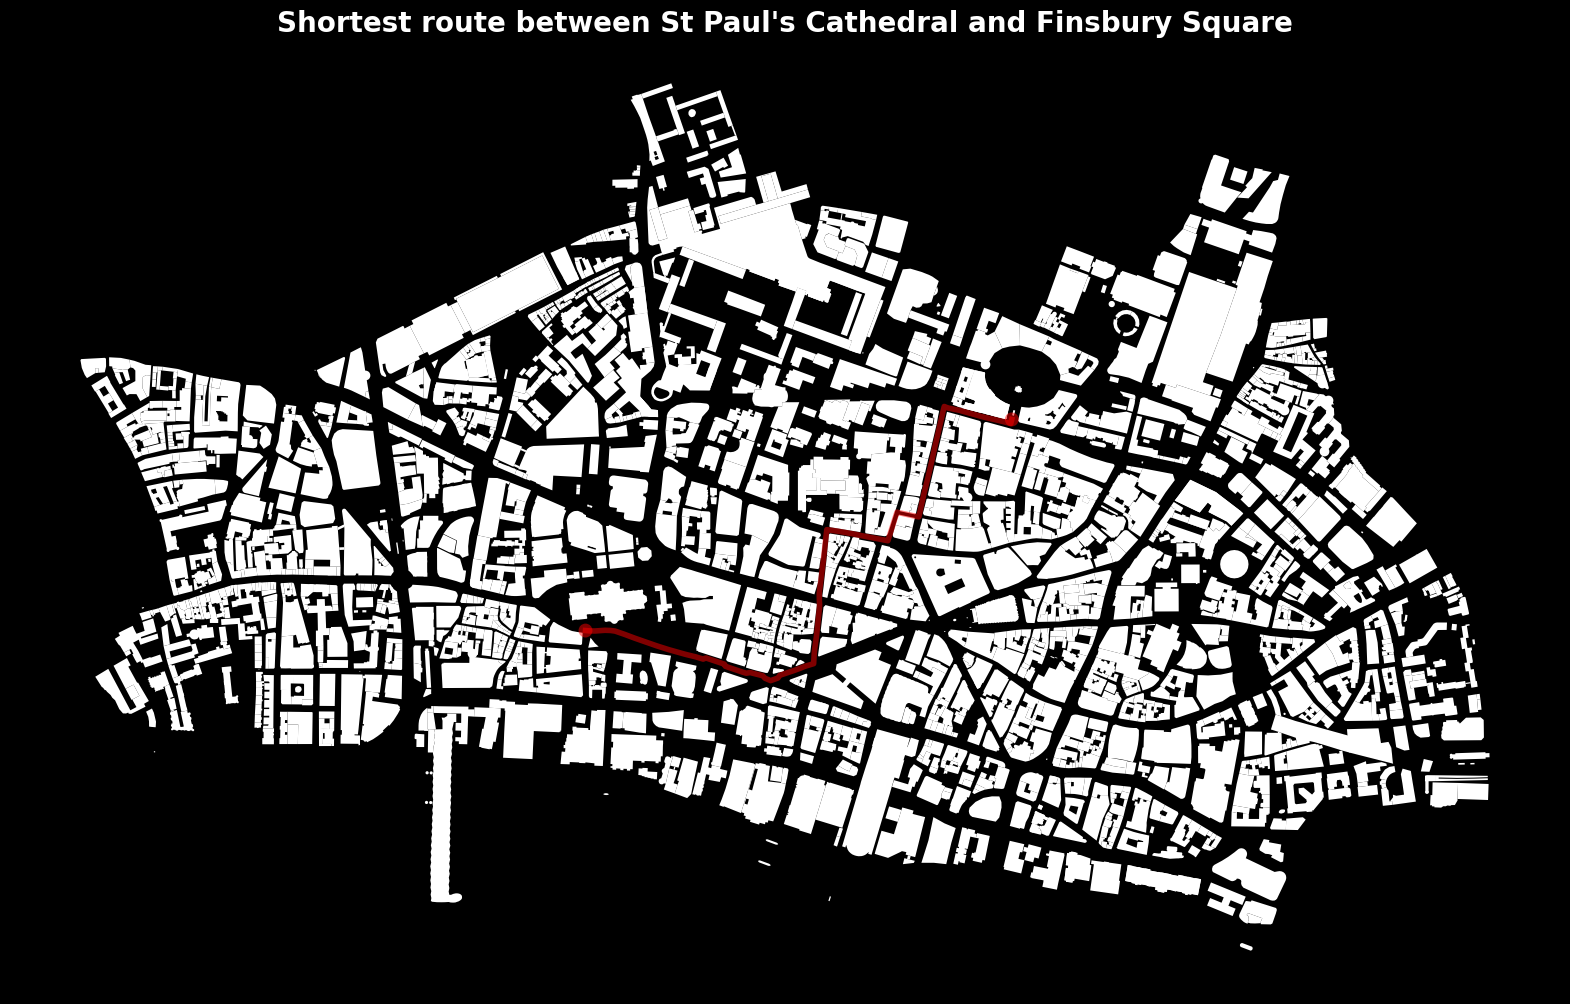

(<Figure size 2000x2000 with 1 Axes>,
 <AxesSubplot: title={'center': "Shortest route between St Paul's Cathedral and Finsbury Square"}>)

In [280]:
st_pauls = buildings[buildings.name.str.contains("St Paul's Cathedral", na=False)].geometry.centroid
finsbury = amenities[amenities.name.str.contains("Finsbury", na=False)].geometry.centroid
print(st_pauls)
print(finsbury)

# get the nearest node to the centroid of St Paul's Cathedral
st_pauls = ox.nearest_nodes(G, st_pauls.x[0], st_pauls.y[0])
print(st_pauls)
# get the nearest node to the centroid of Lloyd's of London
finsbury = ox.nearest_nodes(G, finsbury.x[0], finsbury.y[0])
print(finsbury)

# get the shortest path between the two nodes
route = nx.shortest_path(G, st_pauls, finsbury, weight='length')

# plot the route
fig, ax = plt.subplots(1, 1, figsize=(20, 20), facecolor='k', subplot_kw=dict(aspect='equal'))

# clean it up
ax.set_facecolor('k')
ax.set_axis_off()

# add a title
ax.set_title('Shortest route between St Paul\'s Cathedral and Finsbury Square', fontsize=20, color='w', fontweight='bold')

buildings.plot(color='w', ax=ax)
ox.plot_graph_route(G, route, node_size=2, ax=ax)



In [281]:
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

In [282]:
# get pairs in route in moving window of 2
pairs = [(route[i], route[i+1], 0) for i in range(len(route)-1)]

# the edges index has this weird format, with u, v (for nodes) and then an odd 0
print(edges.index[0])
# so we match it
print(pairs[0])
# # osmnx also has a function to do this, but you're better than that
# pairs = ox.utils_graph.get_route_edge_attributes(G, route, 'length')

# look up the edge data for each pair using the 2 index values u, v
paths = edges[edges.index.isin(pairs)]

# how long is the journey?
paths['length'].sum()

# now we can add distances like this into our gravity models

(104318, 7946372941, 0)
(1678452797, 7223709669, 0)


1355.6879999999999

In [ ]:
# # let's use random walk, as it's fairly intuive in this setting
# partitions = algorithms.walktrap(G)
# neighbourhoods = partitions.communities

In [ ]:
# # let us print some basic states about the communities found
# n_comm = len(neighbourhoods)
# mod = modularity(G, neighbourhoods)

# #performance does not take multigraph
# G_collapsed = ox.utils_graph.get_digraph(G, weight='length')
# performance = partition_quality(G_collapsed, neighbourhoods)
# print(f"""
# {n_comm} communities found
# modularity: {mod}
# performance: {performance}
# """)

In [ ]:
# let's plot to get a better idea of

In [ ]:
# # let's build a dictionary with nodes as keys and cluster assignment
# node_assignment = {}
# for cluster, neighbourhood in enumerate(neighbourhoods):
#     for node in neighbourhood:
#         node_assignment[node] = cluster

In [ ]:
# nx.set_node_attributes(G, node_assignment, 'cluster')

In [ ]:
# cls = ox.plot.get_node_colors_by_attr(G, 'cluster', cmap='tab20')

In [ ]:
# fig, ax = plt.subplots(figsize=(12,7))

# fig, ax = ox.plot_graph(G, 
#                         node_color=cls,
#                         node_size = 25,
#                         ax=ax)